# Configuration model (CM)

In [1]:
import networkx as nx
import numpy as np
import random as rd
import math
import matplotlib.pyplot as plt
from scipy import stats # to do regression for the estimation of the exponent
from scipy.stats import poisson
from network_utils import *

## Parameters

The algorithm has 2 input parameters: 
* N: number of nodes
* p_k : nodes degree distribution

### Size of the network

In [2]:
# Insert Number of Nodes
N = int(input("Insert number of nodes:\n"))

Insert number of nodes:
10000


### Distribution choice
Choose between: 
* Poisson degree distribution (---> generates an ER network)
* Powerlaw degree distribution (---> generates a SF network)

In [3]:
p_k = int(input("Choose the probability distribution:\n--> type 1 for poisson\n--> type 2 for powerlaw\n"))

if p_k not in [1, 2]:
    raise ValueError("Incorrect number!")

Choose the probability distribution:
--> type 1 for poisson
--> type 2 for powerlaw
2


Insert distribution parameter

In [4]:
if p_k== 1:
    lamb = float(input("Insert lambda parameter:\n"))
else:
    gamma = float(input("Insert gamma parameter:\n"))

Insert gamma parameter:
2.8


Now, let's build the degrees list according to the chosen probability distribution

In [5]:
sequence = [1] # degrees list initialized with a 1 to execute the loop

# The degree sequence needs to have an even sum
while sum(sequence) % 2 != 0:
    sequence = []
    
    # Poisson distribution
    if p_k== 1:
        sequence = np.random.poisson(lamb, N)
         
    # Powerlaw distribution
    if p_k == 2:
        
        # Limit the number of self-loops and multiple edges in case of gamma between 2 and 3
        if gamma >= 2 and gamma <=3: 
            k_max = round(math.sqrt(N)) # limit the maximum degree of each node to the square root of N
            
            # generate dhe degree for each node
            for i in range(N):
                prob = float(nx.utils.powerlaw_sequence(n = 1,exponent=gamma)[0])
                deg = int(round(prob))
                
                # re-generate the degree if it's above the above defined threshold
                while deg > k_max:
                    prob = float(nx.utils.powerlaw_sequence(1,exponent=gamma)[0])
                    deg = int(round(prob))
                sequence.append(deg) # add degree to the degrees list
        else:         
            seq=nx.utils.powerlaw_sequence(N,exponent=gamma)
            # round to integer values in the range [0,N]
            sequence = [min(N, max( int(round(s)),0 )) for s in seq]

      
print("Lenght of the sequence: {}".format(len(sequence)))
print("\nSequence of node degrees (first 50 nodes):\n {}".format(sequence[:50]))

Lenght of the sequence: 10000

Sequence of node degrees (first 50 nodes):
 [6, 1, 11, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 6, 1, 2, 1, 2, 1, 1, 2, 1, 3, 1, 2, 1, 1, 8, 2, 3, 1, 3, 4, 2, 1, 1, 2, 1, 1, 2]


## Algorithm
We need now to build a random graph/network with this degree sequence. <br>
Let's build before an empty graph of type MultiGraph, which allows self-loops and multiple edges and then we'll remove them

In [6]:
G = nx.empty_graph(N, create_using = nx.MultiGraph) # MultiGraph because of self-loops

Let's create the list of "stubs", i.e. a list of available degree-repeated nodes. 

In [7]:
#stubs_list = list(chain.from_iterable([n] * d for n, d in enumerate(sequence)))
stubs_list = []
for i in range(N):
    stubs_list += [i for _ in range(sequence[i])]

print(stubs_list[1:50])

[0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 8, 9, 10, 11, 12, 12, 13, 14, 15, 15, 16, 17, 18, 19, 19, 20, 21, 21, 22, 23, 23, 23, 23, 23, 23, 24]


Shuffle the "stubs" list, i.e. perform a random permutation

In [8]:
np.random.shuffle(stubs_list)
print(stubs_list[1:50])

[8616, 6886, 9950, 4414, 3649, 7260, 1718, 3113, 5098, 9814, 4805, 1427, 5145, 5159, 3497, 3090, 9343, 2111, 9116, 9858, 2843, 8430, 759, 2352, 6618, 3738, 8294, 9738, 1501, 9224, 9731, 9978, 6980, 8798, 2181, 7492, 5937, 2388, 5791, 791, 2270, 2753, 8853, 3809, 2766, 8563, 9453, 8576, 8076]


Now we need to creade edges among the nodes in the "stubs" list. We could use two different options:
* A first option could be to bipartition the shuffled slot vector to have a random pairing of nodes. This allows to use the add_edges_from function of networkx that creates links between the 2 partitions<br>

In [9]:
#half = len(slots) // 2

#out_slots, in_slots = stubs_list[:half],stubs_list[half:]
#G.add_edges_from(zip(out_slots, in_slots)) # with zip we create a series of tuples from the 2 lists

* The 2nd option, that is the one we use, is to add edges between consecutive pairs of nodes in the shuffled list <br>

In [10]:
for i in range(0, len(stubs_list), 2):
    G.add_edge(stubs_list[i], stubs_list[i+1])

### Parallel edges and self-loops
Let's first check the presence of self-loops

In [11]:
# number of self-loops
nx.number_of_selfloops(G)

1

In [12]:
# nodes with a self-loop
list(nx.nodes_with_selfloops(G))

[5066]

Multiple edges

In [13]:
arr = nx.to_numpy_matrix(G)
num_multiedges = np.sum(arr>=2) / 2 # divide by two as graph is undirected 
num_multiedges

2.0

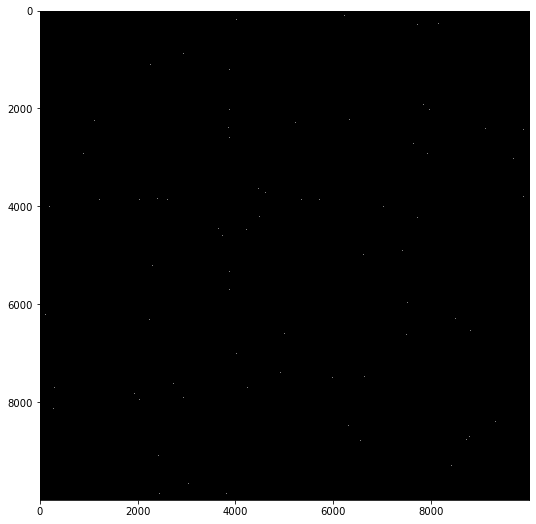

In [14]:
# Visualize multiple edges
plt.figure(figsize=(16,9))
plt.imshow(arr, interpolation='nearest', cmap='gray')
plt.show()

Remove parallel edges and self-loops

In [15]:
G = nx.Graph(G) # removes parallel edges
G.remove_edges_from(nx.selfloop_edges(G)) # removes selfloops

arr = nx.to_numpy_matrix(G)
num_multiedges = np.sum(arr>=2) / 2 # divide by two as graph is undirected 


nx.number_of_selfloops(G), int(num_multiedges)

(0, 0)

### Save the network

In [16]:
nx.write_pajek(G, "test.net")
#nx.write_gexf(G, "test.gexf")

## Network descriptors

In [17]:
print("Number of nodes: {}".format(G.number_of_nodes()))
#G.nodes()

print("Number of edges: {}".format(G.number_of_edges()))
#G.edges()

degrees_values = [val for key,val in G.degree()] # degree for each node
#degrees_values

print("Min degree: {}".format(np.min(degrees_values)))
print("Max degree: {}".format(np.max(degrees_values)))
print("Avg degree: {}".format(round(np.mean(degrees_values), 4)))
#G = nx.Graph(G)

print("Clustering: {}".format(round(nx.average_clustering(G), 4)))
print("Assortativity: {}".format(round(nx.degree_assortativity_coefficient(G), 4)))
if nx.is_connected(G):
    print("Avg path length: {}".format(round(nx.average_shortest_path_length(G), 4)))
    print("Diameter: {}".format(nx.diameter(G)))

Number of nodes: 10000
Number of edges: 10701
Min degree: 1
Max degree: 89
Avg degree: 2.1402
Clustering: 0.0006
Assortativity: -0.0117


## Plots

### Plotting the network
Plot only small size networks

In [18]:
if N <= 100:
    nx.draw(G, alpha = .3, edge_color = '#40a6d1', node_color = '#40a6d1', node_size=30, with_labels = True)

### Plotting the distribution

We use the auxiliary functions we defined in network_utils for visualizing the distribution using either linear or log-log scale. <br>

C:\Users\denal\OneDrive\Desktop\network-models-generators\network_utils.py:45: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(w, z, 'k-', color='#7f7f7f')


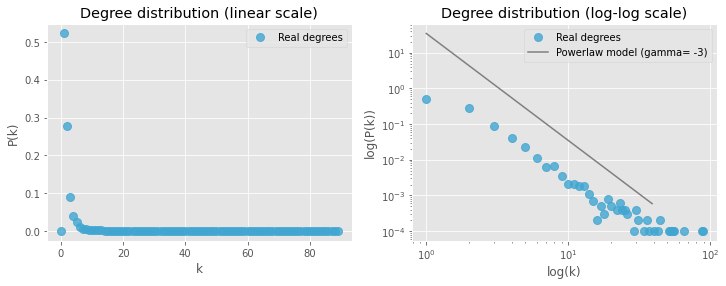

In [19]:
plt.figure(figsize=(12,4))
plt.style.use('ggplot')

# case of Poisson distribution
if p_k == 1:
    plt.subplot(1, 2, 1)
    plot_distrib_lin(graph=G, fit_poisson = True, fit_lambda = lamb, colour='#40a6d1', alpha=.8, expct_lo=0, expct_hi=20)
    plt.subplot(1, 2, 2)
    plot_distrib_log(graph=G, colour='#40a6d1', alpha=.8, fit_line=False, expct_lo=1, expct_hi=50, expct_const=3)

    # powerlaw distribution
else:
    plt.subplot(1, 2, 1)
    plot_distrib_lin(graph=G, colour='#40a6d1', alpha=.8)
    plt.subplot(1, 2, 2)
    plot_distrib_log(graph=G, colour='#40a6d1', alpha=.8, fit_line=True, expct_lo=1, expct_hi=40, expct_const=35)

plt.show()

### Degree distribution histograms

In [20]:
# Auxiliary function to create logaritmically spaced bins (for log-log histogram) by specifying the number of bins
def create_log_bins(degrees, num = 20):
    bins = np.logspace(np.log10(np.min(degrees)), np.log10(np.max(degrees)), num)
    bins = np.array(bins)
    return bins

In [21]:
# PDF histogram in linear scale
def plot_linear_PDF(G, name='', nbins = 15):
    degrees = [G.degree(n) for n in G.nodes()]
    #plt.figure(figsize=(12,8))
    plt.title('PDF in linear scale', fontsize=15)
    plt.xlabel('Degree', fontsize=13)
    plt.ylabel('PDF', fontsize=13)
    plt.hist(degrees, bins=nbins, density = True, cumulative = False)
    plt.tight_layout()
    plt.style.use('ggplot')
        
#plot_linear_PDF(G)

In [22]:
# PDF histogram in Log-Log scale
def plot_loglog_PDF(G, name="", nbins=20):
    degrees = [G.degree(n) for n in G.nodes()]
    
    # creating logaritmically spaced bins
    bins = create_log_bins(degrees, num = nbins)
    
    #plt.figure(figsize=(12,8))
    plt.title('PDF in log-log scale',  fontsize=15)
    plt.xlabel('Degree', fontsize=13)
    plt.ylabel('PDF', fontsize=13)
    plt.yscale('log')
    plt.xscale('log')
    plt.hist(degrees, bins=bins, density = True, cumulative = False)
    plt.tight_layout()
    #plt.style.use('ggplot')

#plot_loglog_PDF(G)

In [23]:
# CCDF histogram in linear scale
def plot_linear_CCDF(G, name="", nbins=30):
    degrees = [G.degree(n) for n in G.nodes()]
    #plt.figure(figsize=(12,8))
    plt.title('CCDF in linear scale', fontsize=15)
    plt.xlabel('Degree', fontsize=13)
    plt.ylabel('CCDF', fontsize=13)
    plt.hist(degrees, bins=nbins, density = True, cumulative = -1)
    plt.tight_layout()
    #plt.style.use('ggplot')

#plot_linear_CCDF(G)

In [24]:
# CCDF histogram in Log-Log scale
def plot_loglog_CCDF(G, name="", nbins=30):
    degrees = [G.degree(n) for n in G.nodes()]
    
    # creating logaritmically spaced bins
    bins = create_log_bins(degrees, num=nbins)
    
    #plt.figure(figsize=(12,8))
    plt.title('CCDF in log-log scale', fontsize=15)
    plt.xlabel('Degree', fontsize=13)
    plt.ylabel('CCDF', fontsize=13)
    plt.yscale('log')
    plt.xscale('log')
    plt.hist(degrees, bins=bins, density = True, cumulative = -1)
    plt.tight_layout()
    #plt.style.use('ggplot')
    
#plot_loglog_CCDF(G)

In [25]:
# number of bins to use
n_bins = 20

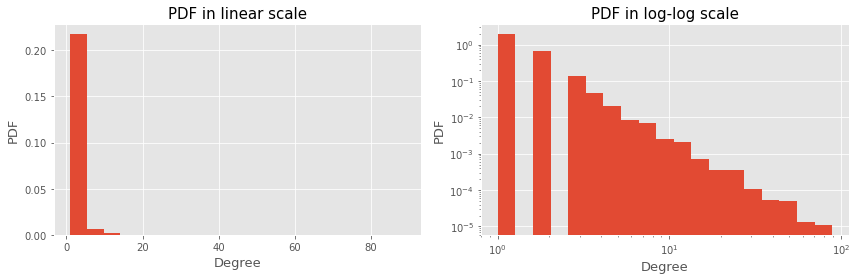

In [26]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plot_linear_PDF(G, nbins=n_bins) 
plt.subplot(1, 2, 2)
plot_loglog_PDF(G, nbins=n_bins)
plt.show()

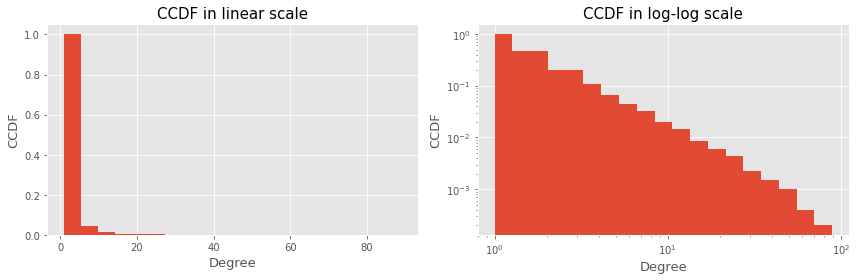

In [27]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plot_linear_CCDF(G, nbins=n_bins) 
plt.subplot(1, 2, 2)
plot_loglog_CCDF(G, nbins=n_bins)
plt.show()

## Estimation of the exponent for the empirical degree distributions of BA and CM(SF), for the networks of size N>=1000.
We'll see 3 main approaches for estimating the exponent of a scale-free network:
* MLE
* Linear regression on the binned PDF histogram
* Linear regression on the binned CCDF histogram

Let's see these three approaches and then we'll compare the results obtained by each one of them

### Using MLE
* We can use the <i>powerlaw</i> Python package described here: https://arxiv.org/abs/1305.0215, which is based on a MLE of the exponent of a powerlaw distribution . <br>
As described in the paper https://arxiv.org/abs/0706.1062, the <i>powerlaw</i> package we use performs the exponent estimation by following the formula 3.7 <br>
According to the paper, the first step to perform a maximum likelihood fit to a powerlaw is to determine what portion of the data to fit. A heavy-tailed
distribution's interesting feature is, indeed, the tail and its properties, so if the initial, small values of the data
do not follow a power law distribution we may opt to disregard them. The question is from what
minimal value xmin (Kmin) the scaling relationship of the power law begins. The methods descibed in the paper of Clauset et al. mentioned above find this optimal value of xmin by creating a powerlaw fit starting from each unique value in the dataset, then selecting the one that results in the minimal Kolmogorov-Smirnov distance, D, between the data and the fit. Therefore the algorithm finds xmin my minimizing D. <br> <br>
* While the maximum likelihood fit to a continous power law can be calculated analytically,
and thus the optimal xmin and resulting fitted parameters can be computed quickly, this is not so for the discrete case. The maximum likelihood fit for a discrete power law is found by numerical optimization,
the computation of which for every possible value of xmin can take time. To circumvent this issue,
powerlaw can use an analytic estimate of gamma, from [https://arxiv.org/abs/0706.1062], which can "give results accurate to about 1% or
better provided xmin ≥ 6".




In [ ]:
#pip install powerlaw
#pip install mpmath 

In [31]:
import powerlaw

degrees = [G.degree(n) for n in G.nodes()]
results = powerlaw.Fit(degrees, discrete = True)
print("\n\nExponent estimation:")
print(round(results.power_law.alpha, 4))
#print(results.power_law.xmin)

Calculating best minimal value for power law fit
xmin progress: 97%

Exponent estimation:
2.7899


### Using Linear Regression

In [32]:
# find min and max of the degrees
Kmin = np.min(degrees)
Kmax = np.max(degrees)

Kmin, Kmax

(1, 89)

In [33]:
# calculate the logarithm of K_i for all the data elements
log_degrees = [np.log10(G.degree(n)) for n in G.nodes()]
#log_degrees

In [34]:
# calculate useful logs
log_Kmin = np.log10(Kmin)
#log_Kmax = np.log10(Kmax)
log_Kmax_1 = np.log10(Kmax + 1)
log_Kmin, log_Kmax_1

(0.0, 1.954242509439325)

Divide the interval in equal size bins and build the bind

In [35]:
# length of the interval
interval_length = (log_Kmax_1 - log_Kmin) / n_bins

# build the bins
bins = []
for i in range(n_bins):
    bins.append(log_Kmin + interval_length * i)
bins.append(log_Kmax_1)
bins

[0.0,
 0.09771212547196625,
 0.1954242509439325,
 0.29313637641589874,
 0.390848501887865,
 0.4885606273598313,
 0.5862727528317975,
 0.6839848783037638,
 0.78169700377573,
 0.8794091292476963,
 0.9771212547196626,
 1.0748333801916288,
 1.172545505663595,
 1.2702576311355613,
 1.3679697566075275,
 1.465681882079494,
 1.56339400755146,
 1.6611061330234262,
 1.7588182584953926,
 1.8565303839673588,
 1.954242509439325]

In [36]:
# Count how many elements ki have their log(ki) in each bin
counts = []
for i in range(n_bins):
    counts.append(len([deg for deg in log_degrees if deg >= bins[i] and deg < bins[i+1]]))

counts

[5226,
 0,
 0,
 2780,
 914,
 0,
 406,
 347,
 61,
 102,
 42,
 48,
 17,
 23,
 12,
 9,
 5,
 5,
 1,
 2]

In [37]:
# Dividing the number of elements in each bin by the total number of elements n we get estimations for the probabilities p_b of each bin
probs = [deg/ N for deg in counts]
probs # probabilities of each bin

[0.5226,
 0.0,
 0.0,
 0.278,
 0.0914,
 0.0,
 0.0406,
 0.0347,
 0.0061,
 0.0102,
 0.0042,
 0.0048,
 0.0017,
 0.0023,
 0.0012,
 0.0009,
 0.0005,
 0.0005,
 0.0001,
 0.0002]

In [38]:
np.sum(probs)

0.9999999999999998

### Linear regression on the PDF

We now need to make the linear regression of pairs (x_b, log_pb) to obtain the regression line. <br>
Let's first calculate the elements of log_pb


In [39]:
log_PDF_p = [np.log10(p) for p in probs]
log_PDF_p

C:\Users\denal\AppData\Local\Temp/ipykernel_14712/502823365.py:1: RuntimeWarning: divide by zero encountered in log10
  log_PDF_p = [np.log10(p) for p in probs]


[-0.2818305946086932,
 -inf,
 -inf,
 -0.5559552040819237,
 -1.0390538042661686,
 -inf,
 -1.391473966422806,
 -1.4596705252091262,
 -2.214670164989233,
 -1.9913998282380825,
 -2.3767507096020997,
 -2.318758762624413,
 -2.769551078621726,
 -2.638272163982407,
 -2.9208187539523753,
 -3.0457574905606752,
 -3.3010299956639813,
 -3.3010299956639813,
 -4.0,
 -3.6989700043360187]

We may have some infinite values: let's remove them from the list

In [40]:
# list containing indices of the infinite elements
inf_indices = []

# populate the list
for i in range(len(log_PDF_p)):
    if math.isinf(log_PDF_p[i]):
        inf_indices.append(i)
               
inf_indices

[1, 2, 5]

In [41]:
# select only finite elements:
log_PDF_p = [v for v in log_PDF_p if not math.isinf(v)]
log_PDF_p

[-0.2818305946086932,
 -0.5559552040819237,
 -1.0390538042661686,
 -1.391473966422806,
 -1.4596705252091262,
 -2.214670164989233,
 -1.9913998282380825,
 -2.3767507096020997,
 -2.318758762624413,
 -2.769551078621726,
 -2.638272163982407,
 -2.9208187539523753,
 -3.0457574905606752,
 -3.3010299956639813,
 -3.3010299956639813,
 -4.0,
 -3.6989700043360187]

The X vector of the linear regression is the bins vector, except from the first element <br>

In [42]:
X = bins[1:]

# we should select only elements corresponding to finite values of the correspondig log_PDF_p
x_2 = []
for i in range(len(X)):
    if i not in inf_indices:
        x_2.append(X[i])
X = x_2
X

[0.09771212547196625,
 0.390848501887865,
 0.4885606273598313,
 0.6839848783037638,
 0.78169700377573,
 0.8794091292476963,
 0.9771212547196626,
 1.0748333801916288,
 1.172545505663595,
 1.2702576311355613,
 1.3679697566075275,
 1.465681882079494,
 1.56339400755146,
 1.6611061330234262,
 1.7588182584953926,
 1.8565303839673588,
 1.954242509439325]

The Y vector of the linear regression is log_PDF_pLog_pb

In [43]:
Y = log_PDF_p
Y

[-0.2818305946086932,
 -0.5559552040819237,
 -1.0390538042661686,
 -1.391473966422806,
 -1.4596705252091262,
 -2.214670164989233,
 -1.9913998282380825,
 -2.3767507096020997,
 -2.318758762624413,
 -2.769551078621726,
 -2.638272163982407,
 -2.9208187539523753,
 -3.0457574905606752,
 -3.3010299956639813,
 -3.3010299956639813,
 -4.0,
 -3.6989700043360187]

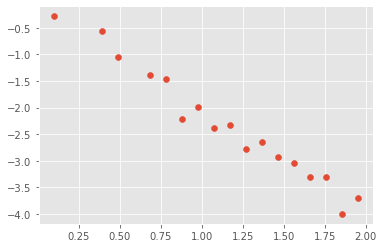

In [44]:
plt.scatter(X, Y)
plt.show()

Let's perform the Linear Regression by using the stats function of the scipy package

In [45]:
regr = stats.linregress(X, Y)

We are interested in the slope of the regression line, indeed the estimation of the exponent is: <br>
* gamma = -slope + 1

In [46]:
print("Slope: ", regr.slope)
exponent_estimation =  - regr.slope + 1
print("\nExponent estimation:", exponent_estimation)

Slope:  -1.9537238013314766

Exponent estimation: 2.953723801331477


### Linear regression on the CCDF

Another alternative for the estimation of exponent gamma consists in doing exactly the same as above but for the complementary cumulative distribution function (CCDF) instead of the probability density function (PDF). <br>
CCDF is calculated from the PDF just by summing up 
the probabilities of all the bins to the right of the bin you are considering (this one included in the sum). 

In [47]:
# probabilities of the bins
probs

[0.5226,
 0.0,
 0.0,
 0.278,
 0.0914,
 0.0,
 0.0406,
 0.0347,
 0.0061,
 0.0102,
 0.0042,
 0.0048,
 0.0017,
 0.0023,
 0.0012,
 0.0009,
 0.0005,
 0.0005,
 0.0001,
 0.0002]

In [48]:
# compute CCDF by summing on the right
CCDF_c = []
for i in range(len(probs)):
    CCDF_c.append(np.sum(probs[i:]))

In [49]:
CCDF_c

[0.9999999999999998,
 0.4774,
 0.4774,
 0.47740000000000005,
 0.1994,
 0.10800000000000001,
 0.10800000000000003,
 0.0674,
 0.03270000000000001,
 0.026599999999999995,
 0.016399999999999998,
 0.012199999999999999,
 0.0073999999999999995,
 0.0057,
 0.0034,
 0.0022,
 0.0013000000000000002,
 0.0008,
 0.00030000000000000003,
 0.0002]

We now need to make the linear regression of pairs (x_b and log_pb) to obtain the regression line.<br>
Let's first calculate the elements of log(cb)

In [50]:
log_CCDF_c = [np.log10(c) for c in CCDF_c]
log_CCDF_c

[-9.643274665532872e-17,
 -0.32111758532926427,
 -0.32111758532926427,
 -0.3211175853292642,
 -0.7002748460243631,
 -0.9665762445130502,
 -0.9665762445130502,
 -1.1713401034646802,
 -1.4854522473397138,
 -1.5751183633689332,
 -1.7851561519523023,
 -1.9136401693252518,
 -2.1307682802690238,
 -2.2441251443275085,
 -2.468521082957745,
 -2.657577319177794,
 -2.886056647693163,
 -3.0969100130080562,
 -3.5228787452803374,
 -3.6989700043360187]

Again, as before, we may have infinite values that we should remove

In [51]:
# list containing indices of the infinite elements
inf_indices = []

for i in range(len(log_CCDF_c)):
    if math.isinf(log_CCDF_c[i]):
        inf_indices.append(i)
               
inf_indices

[]

In [52]:
# select only finite elements:
log_CCDF_c = [v for v in log_CCDF_c if not math.isinf(v)]
log_CCDF_c

[-9.643274665532872e-17,
 -0.32111758532926427,
 -0.32111758532926427,
 -0.3211175853292642,
 -0.7002748460243631,
 -0.9665762445130502,
 -0.9665762445130502,
 -1.1713401034646802,
 -1.4854522473397138,
 -1.5751183633689332,
 -1.7851561519523023,
 -1.9136401693252518,
 -2.1307682802690238,
 -2.2441251443275085,
 -2.468521082957745,
 -2.657577319177794,
 -2.886056647693163,
 -3.0969100130080562,
 -3.5228787452803374,
 -3.6989700043360187]

X vector is the bins vector, except from the first element <br>

In [53]:
X = bins[1:]

# we should select only elements corresponding to finite values of the correspondig log_PDF_p
x_2 = []
for i in range(len(X)):
    if i not in inf_indices:
        x_2.append(X[i])
X = x_2
X

[0.09771212547196625,
 0.1954242509439325,
 0.29313637641589874,
 0.390848501887865,
 0.4885606273598313,
 0.5862727528317975,
 0.6839848783037638,
 0.78169700377573,
 0.8794091292476963,
 0.9771212547196626,
 1.0748333801916288,
 1.172545505663595,
 1.2702576311355613,
 1.3679697566075275,
 1.465681882079494,
 1.56339400755146,
 1.6611061330234262,
 1.7588182584953926,
 1.8565303839673588,
 1.954242509439325]

Y vector is the log_CCDF_c vector computed above

In [54]:
Y = log_CCDF_c

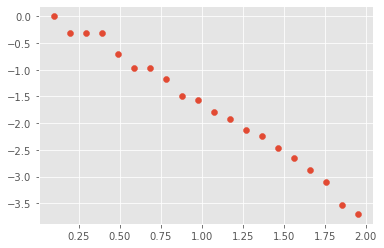

In [55]:
plt.scatter(X, Y)
plt.show()

Let's perform the Linear Regression by using the stats function of the scipy package: the procedure is the same as before.

In [56]:
regr = stats.linregress(X, Y)
print("Slope: ", regr.slope)
exponent_estimation =  - regr.slope + 1
print("\nExponent estimation:", exponent_estimation)

Slope:  -1.923510357001308

Exponent estimation: 2.923510357001308


#### Conclusion on exponent estimation
Binning-based approaches, i.e. the 2 approaches we saw based on constructing bins and performing regression on the binned data,  perform poorly. <br>
As we can easily imagine, in binning-based approaches the estimated exponent is highly dependent on the choice of bin width, and this dependency varies as a function of sample size ( [https://esajournals.onlinelibrary.wiley.com/doi/10.1890/07-1288.1White]). <br>
In general, binning results in a loss of
information about the distributions of points within a
bin and is thus expected to perform poorly (Clauset et al.
2007, Edwards et al. 2007). Therefore, while binning is
useful for visualizing the frequency distribution, and
normalized logarithmic binning performs well at this
task, binning-based approaches should be avoided for
parameter estimation (Clauset et al. 2007). <br>

Maximum likelihood estimation performs best in estimating the powerlaw exponent.